In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
using LinearAlgebra
using JLD2
using Test
const resfile = joinpath(@__DIR__, "q1.jld2")

"/home/brian/Classes/16745_OptimalControl/hw1_solutions/src/q1.jld2"

# Question 1: Implicit Integrators (25 pts)
In this question we'll be taking a deeper look into implicit integration techniques, and some of the advantages they bring.

## Part (a): Implicit Midpoint (3 pts)
Implement implicit midpoint integration for the simple pendulum with $m = l = 1$ and $g = 9.81$:

Recall from lecture that implicit integration is defined by the following formula:
$$ x_{n+1} = x_n + h f\left(\frac{x_{n+1} + x_n}{2}\right) $$

In order to use an implicit integrator, we need to solve a root-finding problem using Newton's method. For convenience, we'll define a function `implicit_midpoint` that outputs 
the residual error of our integrator:

$$ x_n + h f\left(\frac{x_{n+1} + x_n}{2}\right) - x_{n+1} = 0 $$


**NOTE**: Our `implicit_midpoint` function accepts as it's first input a function handle `f`. In Julia, functions are themselves objects and can be passed to other functions. For this problem, our function `f` will always be `pendulum_dynamics`, so you'd call your implicit midpoint method like: `implicit_midpoint(pendulum_dynamics, x1, x2, h)`

In [2]:
# TASK: Implement the `pendulum_dynamics` function
#  TIP: When allocating the xdot vector, be sure to use `zero(x)` to make it the same type as the input vector.
#       This makes it work with ForwardDiff, since `eltype(x)` will be a ForwardDiff.Dual type.
"""
    pendulum_dynamics(x; [m, l, g])

Returns the derivative of the state vector `x = [θ, ω]`, given mass `m`, length `l`, and gravity `g`.
"""
function pendulum_dynamics(x; m=1, l=1, g=9.81)
    # TODO: Implement this method
    xdot = zero(x)
    
    # SOLUTION
    θ = x[1]
    ω = x[2]
    xdot[1] = ω
    xdot[2] = -g/l*sin(θ)
    return xdot
end

# TASK: Implement the `implicit_midpoint_pendulum!` function
"""
    x2 = implicit_midpoint(f, x1, x2, h)

Evaluate the residual of the implicit midpoint integrator for the dynamics `f` with a time step of `h`.
The dynamics function `f` is expected to take a state vector as an argument. 
"""
function implicit_midpoint(f, x1, x2, h)
    # TODO: Implement this method
    out = zero(x2)
    
    # SOLUTION
    xmid = 0.5 * (x1 + x2)
    out = x1 .+ h * f(xmid) - x2
    return out
end

# SOLUTION: some extra functions to make things easier
function pendulum_jacobian(x; m=1, l=1, g=9.81)
    return [
        0 1;
        -g/l*cos(x[1]) 0;
    ]
end

pendulum_jacobian (generic function with 1 method)

In [30]:
@testset "1a" begin
    f = pendulum_dynamics
    x1 = [0.12, -1.5]
    x2 = [-0.5, 10.2]
    h = 0.1
    @testset "pendulum dynamics" begin
        @test pendulum_dynamics([0,0.]) ≈ zeros(2)
        @test pendulum_dynamics(x1) ≈ load(resfile, "xdot")
    end
    @testset "implicit midpoint" begin
        @test implicit_midpoint(f, zeros(2), zeros(2), h) ≈ zeros(2)
        @test implicit_midpoint(f, x1, x1, 0) ≈ zeros(2)
        @test implicit_midpoint(f, x1, x2, h) ≈ load(resfile, "midpoint_res")
    end
end;

Test Summary: | Pass  Total
1a            |    5      5


## Part (b): Solve using Newton's Method (10 pts)
Use Newton's method to solve for $x_{n+1}$ with initial guess $x_{n+1} = x_n$. Solve such that the 2-norm of the residual is less than 1e-6. 

Recall that Newton's method is an interative root-finding method. Each iteration looks like:

$$ x^{(i+1)} = x^{(i)} - \frac{\partial f}{\partial x}^{-1} f(x) $$

**NOTE**: It should take 5 iterations or less. If it's taking more iterations than that, you're doing something wrong.

In [31]:
# TASK: Complete the following function
using ForwardDiff
"""
    implicit_midpoint_solve!(f,x1,x2,h)

Find the `x2` that satisfies implicit midpoint integration for the pendulum dynamics. 

Should modify `x2` in-place and return a vector of 2-norm residuals. The input value of `x2`
should be used as the initial guess.
"""
function implicit_midpoint_solve!(f, x1, x2, h; ϵ=1e-6)::Vector{Float64}
    # TODO: Implement this function. Feel free to add optional input arguments as needed
    residuals = Float64[]
    
    # SOLUTION
    r(x) = implicit_midpoint(f, x1, x, h)
    # ∇r(x) = ForwardDiff.jacobian(r, x)
    ∇r(x) = implicit_midpoint_jacobian2(x1, x, h)
    for i = 1:10
        # Evaluate the residual and check convergence
        res = r(x2)
        push!(residuals, norm(res))
        if norm(res) < ϵ
            break
        end
        
        # If it hasn't converged, take a Newton step
        dx = -∇r(x2) \ res
        x2 .+= dx
    end
    
    return residuals
end

# SOLUTION: Functions for evaluating the Jacobian of the implicit integrator
function implicit_midpoint_jacobian2(x1, x2, h)
    # Jacobian wrt x2
    xmid = 0.5 * (x2 + x1)
    h * pendulum_jacobian(xmid) * 0.5 - I
end
function implicit_midpoint_jacobian1(x1, x2, h)
    # Jacobian wrt x1
    xmid = 0.5 * (x2 + x1)
    h * pendulum_jacobian(xmid) * 0.5 + I
end

implicit_midpoint_jacobian1 (generic function with 1 method)

In [37]:
let
    f = pendulum_dynamics
    x0 = [deg2rad(45), 0]
    x_next = copy(x0)
    x1 = [0.12, -1.5]
    x2 = [-0.5, 10.2]
    h = 0.1
    
    residuals = implicit_midpoint_solve!(pendulum_dynamics, x0, x_next, h)
    jldopen(resfile, "a+") do file
        file["x_next"] = x_next
    end
end

2-element Vector{Float64}:
  0.7513107220090732
 -0.6817488277675015

In [42]:
@testset "1b" begin
    f = pendulum_dynamics
    x0 = [deg2rad(45), 0]
    h = 0.1
    @testset "Implicit Midpoint Solve" begin
        x_next = copy(x0)
        residuals = implicit_midpoint_solve!(pendulum_dynamics, x0, x_next, h)
        @test residuals[end] < 1e-6
        @test length(residuals) < 5
        @test x_next ≈ load(resfile, "x_next")
    end
end;

Test Summary: | Pass  Total
1b            |    3      3


## Part (c): Energy Analysis (2 pts)
Simulate with $h=0.1$ for 1 hour and plot the total energy of the system vs time:
$$ E = \frac{1}{2} m l^2 \omega^2 + m g l (1 - \cos \theta) $$

Start the simulation with an initial state of 45 degrees and zero velocity.

In [43]:
# TASK: Compute the energy of the system. Store the result in the vector `energy_implicit::Vector{Float64}`
using Plots

# SOLUTION
function simulate(x0, h, T)
    time = range(0,T, step=h)
    x = copy(x0)
    x_next = zero(x)
    X = [copy(x0) for t in time]
    X[1] .= x0
    for i = 1:length(time) - 1
        implicit_midpoint_solve!(pendulum_dynamics, X[i], X[i+1], h)
    end
    return time, X
end

function pendulum_energy(x; m=1, l=1, g=9.81)
    return 0.5*m*l^2*x[2]^2 + m*g*(1-cos(x[1]))
end

x0 = [deg2rad(45), 0]
time, X = simulate(x0, 0.1, 3600);
energy_implicit = pendulum_energy.(X);

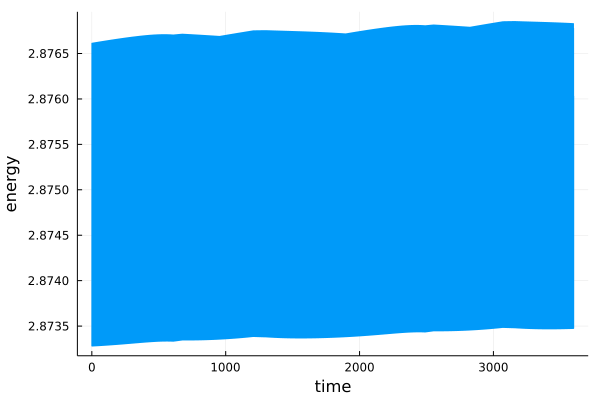

In [33]:
# SOLUTION
plot(time, energy_implicit, xlabel="time", ylabel="energy", label="")

In [52]:
@testset "1c" begin
    @test mean(energy_implicit) ≈ load(resfile, "implicit_energy_mean")
    @test std(energy_implicit) < 0.05
end;

Test Summary: | Pass  Total
1c            |    2      2


## Part (d): RK4 Comparison (5 pts)
Compare the energy behavior of the implicit midpoint integrator with a 4th order Runge Kutta integrator.

In [54]:
# TASK: implement a 4th order Runge Kutta integrator for the pendulum (3 pts)
"""
    rk4(f, x, h)

Integrate the dynamics `f(x)` with a 4th Order Runge Kutta method at state vector `x` and time step `h`.
"""
function rk4(f, x, h)
    # TODO: implement
    xnext = zero(x)
    
    # SOLUTION
    k1 = f(x)
    k2 = f(x + 0.5*h*k1)
    k3 = f(x + 0.5*h*k2)
    k4 = f(x + h*k3)
    xnext = x + 1//6 * (k1 + 2k2 + 2k3 + k4) * h
    
    return xnext
end

rk4

In [57]:
@testset "rk4" begin
    f = pendulum_dynamics
    x = [-0.12, 1.37]
    h = 0.1
    @test rk4(f, x, h) ≈ load(resfile, "rk4")
end;

Test Summary: | Pass  Total
rk4           |    1      1


In [58]:
# TASK: Compute the energy behavior of rk4. Store the result in `energy_rk4::Vector{Float64}` (1 pt)
# TASK: Generate a plot of energy vs time comparing implicit midpoint with rk4 (1 pt)
energy_rk4 = Float64[]

# SOLUTION
function simulate_rk4(f, x0, h, T)
    time = range(0,T, step=h)
    x = copy(x0)
    x_next = zero(x)
    X = [zero(x0) for t in time]
    X[1] .= x0
    for i = 1:length(time) - 1
        X[i+1] = rk4(f, X[i], h)
    end
    return time, X
end

simulate_rk4 (generic function with 1 method)

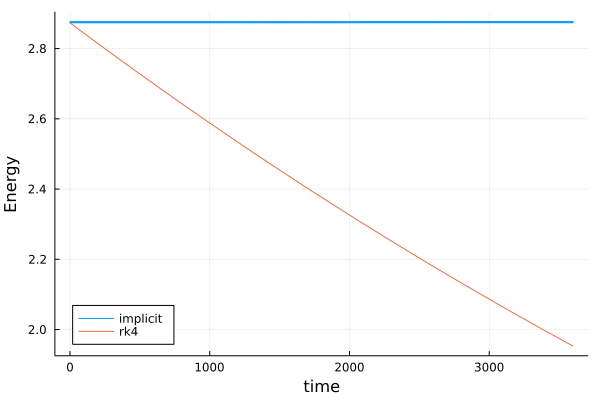

In [59]:
# SOLUTION
time, Xrk4 = simulate_rk4(pendulum_dynamics, x0, 0.1, 3600);
energy_rk4 = pendulum_energy.(Xrk4)
plot(time, energy_implicit, label="implicit", xlabel="time", ylabel="Energy", legend=:bottomleft)
plot!(time, energy_rk4, label="rk4")

In [69]:
@testset "1d" begin
    @test length(energy_rk4) == length(energy_implicit)
    @test energy_rk4[end] < energy_implicit[end]
    @test mean(diff(energy_rk4)) ≈ -2.5e-5 atol=1e-5
    @test std(diff(energy_rk4)) < 1e-3  # should be about linear
end;

Test Summary: | Pass  Total
1d            |    4      4


## Part (e): Evaluating the Jacobian (5 pts)
Computing the Jacobian for an explicit integrator like RK4 is straightforward, since it's just a basic application of the chain rule (you should do this for practice, and can check your result with ForwardDiff). 

Computing the Jacobian for an implicit integrator is not as trivial since we use Newton's method to compute the next step. However, we can use the [implicit function theorem](https://en.wikipedia.org/wiki/Implicit_function_theorem), which can be easily derived by taking a 1st order Taylor series expansion of $f(x,y) = 0$:
$$ f(x,y) = 0 \implies f(x + \Delta x, y + \Delta y) \approx f(x,y) + \frac{\partial f}{\partial x} \Delta x + \frac{\partial f}{\partial y} \Delta y = 0 $$
Dropping $f(x,y)$ (since it's zero) and solving for $\Delta x$ we obtain an expression for our Jacobian:
$$ \Delta x = -\frac{\partial f}{\partial x}^{-1} \frac{\partial f}{\partial y} \Delta y $$

Use this to compute the Jacobian of the implicit integrator, evaluated at $\theta_1 = \omega_1 = 0$ with $h = 0.1$. 

In [72]:
# TASK: Compute the Jacobian of the implicit midpoint integrator for h = 0.1. (3 pts)
#       Store the result in `Amid::Matrix{Float64}` of size (2,2)
Amid = zeros(2,2)

# SOLUTION
x1 = zeros(2)
x2 = zeros(2)
h = 0.1
implicit_midpoint_solve!(pendulum_dynamics, x1, x2, h)

A1 = implicit_midpoint_jacobian1(x1,x2,0.1)
A2 = implicit_midpoint_jacobian2(x1,x2,0.1)

A1 ≈ ForwardDiff.jacobian(x->implicit_midpoint(pendulum_dynamics,x,x2,h), x1)
A2 ≈ ForwardDiff.jacobian(x->implicit_midpoint(pendulum_dynamics,x1,x,h), x2)

Amid = -A2\A1

2×2 Matrix{Float64}:
  0.952124  0.0976062
 -0.957517  0.952124

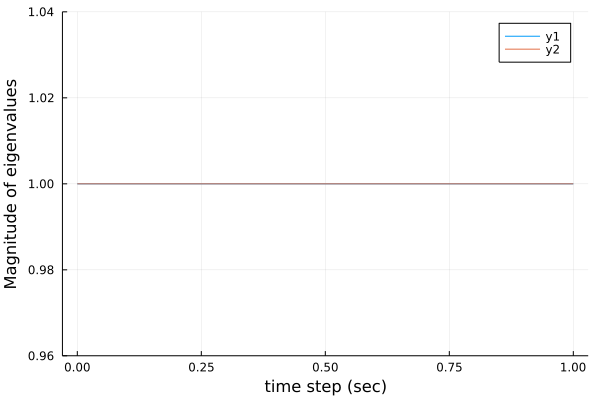

In [73]:
# TASK: Compute the magnitude of the eigenvalues of A for 0 ≤ h ≤ 1.  (1 pt)
#       Store the result in `eigs_implicit::Matrix{Float64}` of size (100,2)
eigs_implicit = zeros(100,2)

# SOLUTION
hs = range(0,1,length=100)
eigs_implicit = map(hs) do h
    A2 = implicit_midpoint_jacobian2(x1,x2,h)
    A1 = implicit_midpoint_jacobian1(x1,x2,h)
    A1 = ForwardDiff.jacobian(x->implicit_midpoint(pendulum_dynamics,x,x2,h), x1)
    A2 = ForwardDiff.jacobian(x->implicit_midpoint(pendulum_dynamics,x1,x,h), x2)
    Amid = -A2\A1
    abs.(eigvals(Amid))
end

# TASK: Plot the eigenvalues vs time step (1 pt)
eigs_implicit = hcat(eigs_implicit...)'
plot(hs, eigs_implicit, xlabel="time step (sec)", ylabel="Magnitude of eigenvalues", ylim=(0.96,1.04))

Obviously something special is going on here. Implicit midpoint is a "symplectic" integrator. That means it conserves energy (up to numerical roundoff/truncation error). Implicit midpoint is also the simplest "collocation" method. More about those later...

In [ ]:
@testset "1e" begin
    @test size(eigs_implicit) == (100,2)
    @test mean(eigs_implicit) ≈ 1.0 atol=1e-6
    @test std(eigs_implicit) ≈ 0 atol=1e-10
    @test Amid ≈ load(resfile, "Amid") atol=1e-6
end

Test Summary: | Pass  Total
1e            |    4      4


Test.DefaultTestSet("1e", Any[], 4, false, false)